<h2>Análise Preditiva de Turnover de Funcionários</h2>

<p>O turnover de funcionários, ou rotatividade, representa um desafio significativo e custoso para empresas de todos os setores, especialmente em áreas competitivas como a de tecnologia. A perda de um colaborador envolve não apenas custos diretos com novos processos seletivos e treinamento, mas também custos indiretos relacionados à perda de conhecimento, impacto na produtividade da equipe e no clima organizacional.
    
Este projeto nasceu de um desejo de aprofundar meus conhecimentos em Ciência de Dados, revisitando uma análise inicial sobre turnover que realizei anteriormente em meus estudos. Agora, no 3º semestre e com uma compreensão mais sólida do pipeline completo de um projeto de dados – desde a análise exploratória até a implementação e avaliação de modelos de Machine Learning –, meu objetivo foi aplicar essas novas habilidades para realizar um estudo mais robusto e gerar insights mais acionáveis.

Utilizando um conjunto de dados anonimizado fornecido pelo departamento de RH de uma empresa de tecnologia fictícia, contendo informações de 1470 funcionários (incluindo status de permanência, dados demográficos, salariais, de satisfação e de histórico profissional), buscamos responder à pergunta central: "Quais políticas ou fatores da empresa deveriam ser ajustados para minimizar o turnover?"

Ao longo deste trabalho, vou realizar uma análise exploratória detalhada para entender os padrões nos dados, pré-processar as informações para prepará-las para modelagem, treinar um modelo de classificação (RandomForestClassifier) para prever a probabilidade de um funcionário sair, e otimizar seus parâmetros e, finalmente, interpretar os resultados para extrair recomendações práticas. O foco principal é tanto gerar valor a partir dos dados quanto solidificar meu aprendizado nas melhores práticas de Ciência de Dados.</p>

---

# Importação de Bibliotecas e Carregamento dos Dados

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image # Para exibir imagens estáticas do Plotly

# Configurar o tema padrão do Plotly e o motor para imagens estáticas
pio.templates.default = "plotly_white"
pio.kaleido.scope.mathjax = None # Evita um possível aviso com Kaleido

# Carregar os dados (assumindo que o arquivo está na pasta 'data')
try:
    data_rh = pd.read_excel('data/Base_RH.xlsx', sheet_name='Base', index_col='ID')
    print("Arquivo 'Base_RH.xlsx' carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'data/Base_RH.xlsx' não encontrado.")
    print("Por favor, certifique-se de que o caminho para o arquivo está correto.")
   
# Exibir as primeiras linhas para confirmar
print("\nPrimeiras 5 linhas do DataFrame:")
display(data_rh.head())

Arquivo 'Base_RH.xlsx' carregado com sucesso!

Primeiras 5 linhas do DataFrame:


,Funcionário_deixou_a_empresa,Idade,Frequência de Viagens,Distância_do_trabalho,Formação,E-Sat,Gênero,Estado_Civil,Salário,Qte_Empresas_Trabalhadas,Faz_hora_extras?,Perc_de_aumento,Qte_ações_da_empresa,Tempo_de_carreira,Horas_de_treinamento,Equilibrio_de_Vida,Tempo_de_empresa,Anos_no_mesmo_cargo,Anos_desde_a_ultima_promocao,Anos_com_o_mesmo_chefe
ID,,,,,,,,,,,,,,,,,,,,
1,Sim,41,Viaja raramente,1,Ensino Técnico,Médio,M,Solteiro,5993,8,Sim,11,0,8,0,Ruim,6,4,0,5
2,Não,49,Viaja frequentemente,8,Ensino Médio,Alto,H,Casado,5130,1,Não,23,1,10,3,Muito bom,10,7,1,7
3,Sim,37,Viaja raramente,2,Ensino Técnico,Muito Alto,H,Solteiro,2090,6,Sim,15,0,7,3,Muito bom,0,0,0,0
4,Não,33,Viaja frequentemente,3,Mestrado,Muito Alto,M,Casado,2909,1,Sim,11,0,8,3,Muito bom,8,7,3,0
5,Não,27,Viaja raramente,2,Ensino Médio,Baixo,H,Casado,3468,9,Não,12,1,6,3,Muito bom,2,2,2,2


In [2]:
#ExibirDimensões do DataFrame
print('')
print(f"Dimensões do DataFrame: {data_rh.shape}")
print("-" * 50)
      
# Exibir informações gerais e tipos de dados
print("\nInformações do DataFrame (Tipos de Dados e Nulos):")
data_rh.info()
print('')
print("-" * 50)

# Confirmar a contagem de nulos 
print("\nContagem de valores nulos por coluna:")
print(data_rh.isnull().sum())


Dimensões do DataFrame: (1470, 20)
--------------------------------------------------

Informações do DataFrame (Tipos de Dados e Nulos):
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 1470
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Funcionário_deixou_a_empresa  1470 non-null   object
 1   Idade                         1470 non-null   int64 
 2   Frequência de Viagens         1470 non-null   object
 3   Distância_do_trabalho         1470 non-null   int64 
 4   Formação                      1470 non-null   object
 5   E-Sat                         1470 non-null   object
 6   Gênero                        1470 non-null   object
 7   Estado_Civil                  1470 non-null   object
 8   Salário                       1470 non-null   int64 
 9   Qte_Empresas_Trabalhadas      1470 non-null   int64 
 10  Faz_hora_extras?              1470 non-null   object
 11  

---

# Análise das Colunas Categóricas

In [3]:
if data_rh is not None:
    colunas_object = data_rh.select_dtypes(include=['object']).columns
    print('')
    print("Analisando valores únicos nas colunas do tipo 'object':\n")
    
    # Iterar sobre cada coluna 'object' e mostrar seus valores únicos e a contagem
    for col in colunas_object:
        num_valores_unicos = data_rh[col].nunique()
        valores_unicos = data_rh[col].unique()
        print(f"Coluna: '{col}'")
        print(f"  Número de valores únicos: {num_valores_unicos}")
        # Mostrar os valores únicos apenas se não forem muitos 
        if num_valores_unicos < 15:
            print(f"  Valores únicos: {valores_unicos}")
        else:
            print(f"  Valores únicos: {valores_unicos[:15]} ... (e mais)") # Mostra apenas os primeiros 15
        print("-" * 30) # Linha separadora
        
else:
    print("Erro: O DataFrame 'data_rh' não foi carregado. Verifique passos anteriores.")


Analisando valores únicos nas colunas do tipo 'object':

Coluna: 'Funcionário_deixou_a_empresa'
  Número de valores únicos: 2
  Valores únicos: ['Sim' 'Não']
------------------------------
Coluna: 'Frequência de Viagens'
  Número de valores únicos: 3
  Valores únicos: ['Viaja raramente' 'Viaja frequentemente' 'Não viaja']
------------------------------
Coluna: 'Formação'
  Número de valores únicos: 5
  Valores únicos: ['Ensino Técnico' 'Ensino Médio' 'Mestrado' 'Ensino Superior' 'Doutorado']
------------------------------
Coluna: 'E-Sat'
  Número de valores únicos: 4
  Valores únicos: ['Médio' 'Alto' 'Muito Alto' 'Baixo']
------------------------------
Coluna: 'Gênero'
  Número de valores únicos: 2
  Valores únicos: ['M' 'H']
------------------------------
Coluna: 'Estado_Civil'
  Número de valores únicos: 3
  Valores únicos: ['Solteiro' 'Casado' 'Divorciado']
------------------------------
Coluna: 'Faz_hora_extras?'
  Número de valores únicos: 2
  Valores únicos: ['Sim' 'Não']
------

---

- Funcionário_deixou_a_empresa: Binária ('Sim', 'Não'). variável alvo.
- Frequência de Viagens: Categórica, mas com uma ordem clara ('Não viaja' < 'Viaja raramente' < 'Viaja frequentemente'). Ordinal.
- Formação: Categórica com ordem clara ('Ensino Médio' < 'Ensino Técnico' < 'Ensino Superior' < 'Mestrado' < 'Doutorado'). Ordinal.
- E-Sat: Categórica com ordem clara ('Baixo' < 'Médio' < 'Alto' < 'Muito Alto'). Ordinal.
- Gênero: Binária ('M', 'H'). Nominal.
- Estado_Civil: Categórica com 3 níveis ('Solteiro', 'Casado', 'Divorciado'). Nominal.
- Faz_hora_extras?: Binária ('Sim', 'Não'). Nominal.
- Equilibrio_de_Vida: Categórica com ordem clara ('Ruim' < 'Bom' < 'Muito bom' < 'Excelente'). Ordinal.

# Mapeamento de Variáveis Binárias e Ordinais

In [4]:
# Criar cópia do DataFrame para manter o original sem alteração
data_rh_proc = data_rh.copy()

In [5]:
if data_rh_proc is not None:
    # Mapeamentos
    map_sim_nao = {'Sim': 1, 'Não': 0}
    map_genero = {'H': 0, 'M': 1} # Homen=0, Mulher=1 
    map_freq_viagens = {'Não viaja': 0, 'Viaja raramente': 1, 'Viaja frequentemente': 2}
    
    # Definindo a ordem de Formação 
    map_formacao = {'Ensino Médio': 0, 'Ensino Técnico': 1, 'Ensino Superior': 2, 'Mestrado': 3, 'Doutorado': 4}
    map_e_sat = {'Baixo': 0, 'Médio': 1, 'Alto': 2, 'Muito Alto': 3}
    map_equilibrio_vida = {'Ruim': 0, 'Bom': 1, 'Muito bom': 2, 'Excelente': 3}
    
    # Aplicar mapeamentos
    data_rh_proc['Funcionário_deixou_a_empresa'] = data_rh_proc['Funcionário_deixou_a_empresa'].map(map_sim_nao)
    data_rh_proc['Faz_hora_extras?'] = data_rh_proc['Faz_hora_extras?'].map(map_sim_nao)
    data_rh_proc['Gênero'] = data_rh_proc['Gênero'].map(map_genero)
    data_rh_proc['Frequência de Viagens'] = data_rh_proc['Frequência de Viagens'].map(map_freq_viagens)
    data_rh_proc['Formação'] = data_rh_proc['Formação'].map(map_formacao)
    data_rh_proc['E-Sat'] = data_rh_proc['E-Sat'].map(map_e_sat)
    data_rh_proc['Equilibrio_de_Vida'] = data_rh_proc['Equilibrio_de_Vida'].map(map_equilibrio_vida)
    
    print("Mapeamentos aplicados com sucesso!")
    
    # Verificar os tipos de dados novamente
    print("\nNovas informações do DataFrame (após mapeamento):")
    print('')
    print('-' * 50)
    print('')
    data_rh_proc.info()
    
    # Verificar os valores únicos das colunas modificadas
    print("\nValores únicos nas colunas modificadas:")
    print('')
    print('-' * 50)
    print('')
    colunas_modificadas = list(map_sim_nao.keys()) + list(map_genero.keys()) + \
                         list(map_freq_viagens.keys()) + list(map_formacao.keys()) + \
                         list(map_e_sat.keys()) + list(map_equilibrio_vida.keys())
    
    # Na verdade, vamos pegar os nomes das colunas que mapeamos
    colunas_mapeadas = ['Funcionário_deixou_a_empresa', 'Faz_hora_extras?', 'Gênero',
                        'Frequência de Viagens', 'Formação', 'E-Sat', 'Equilibrio_de_Vida']
    
    for col in colunas_mapeadas:
        print(f"Coluna '{col}': {data_rh_proc[col].unique()}")
    
    # Exibir as primeiras linhas do DF processado
    print('')
    print('-' * 50)
    print("\nPrimeiras 5 linhas do DataFrame Processado:")
   
    display(data_rh_proc.head())
else:
    print("Erro: O DataFrame 'data_rh' não foi carregado. Verifique passos anteriores.")

Mapeamentos aplicados com sucesso!

Novas informações do DataFrame (após mapeamento):

--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 1470
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Funcionário_deixou_a_empresa  1470 non-null   int64 
 1   Idade                         1470 non-null   int64 
 2   Frequência de Viagens         1470 non-null   int64 
 3   Distância_do_trabalho         1470 non-null   int64 
 4   Formação                      1470 non-null   int64 
 5   E-Sat                         1470 non-null   int64 
 6   Gênero                        1470 non-null   int64 
 7   Estado_Civil                  1470 non-null   object
 8   Salário                       1470 non-null   int64 
 9   Qte_Empresas_Trabalhadas      1470 non-null   int64 
 10  Faz_hora_extras?              1470 non-null   int64 
 11  

,Funcionário_deixou_a_empresa,Idade,Frequência de Viagens,Distância_do_trabalho,Formação,E-Sat,Gênero,Estado_Civil,Salário,Qte_Empresas_Trabalhadas,Faz_hora_extras?,Perc_de_aumento,Qte_ações_da_empresa,Tempo_de_carreira,Horas_de_treinamento,Equilibrio_de_Vida,Tempo_de_empresa,Anos_no_mesmo_cargo,Anos_desde_a_ultima_promocao,Anos_com_o_mesmo_chefe
ID,,,,,,,,,,,,,,,,,,,,
1,1,41,1,1,1,1,1,Solteiro,5993,8,1,11,0,8,0,0,6,4,0,5
2,0,49,2,8,0,2,0,Casado,5130,1,0,23,1,10,3,2,10,7,1,7
3,1,37,1,2,1,3,0,Solteiro,2090,6,1,15,0,7,3,2,0,0,0,0
4,0,33,2,3,3,3,1,Casado,2909,1,1,11,0,8,3,2,8,7,3,0
5,0,27,1,2,0,0,0,Casado,3468,9,0,12,1,6,3,2,2,2,2,2


---

# (EDA) - Entendendo o Problema Principal

## Visualização da Taxa de Turnover

Distribuição do Turnover:
--------------------------------------------------

Funcionário_deixou_a_empresa
0    1233
1     237
Name: count, dtype: int64

Percentual do Turnover:
--------------------------------------------------

Funcionário_deixou_a_empresa
0    83.88
1    16.12
Name: proportion, dtype: float64


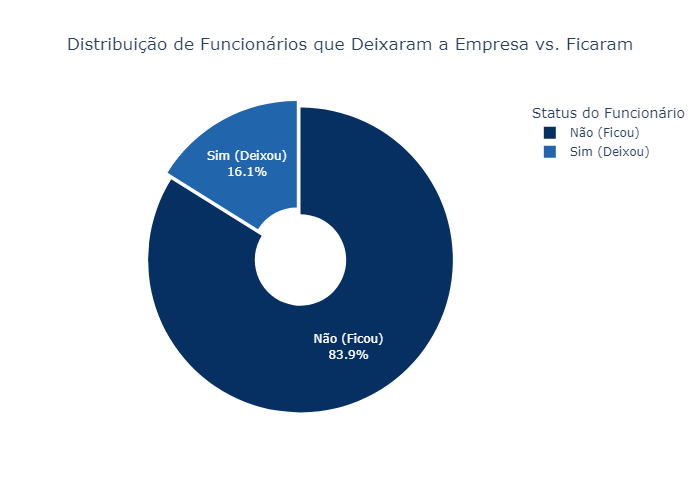

In [6]:
if data_rh_proc is not None:

    # Calcular a contagem e a proporção de turnover
    turnover_counts = data_rh_proc['Funcionário_deixou_a_empresa'].value_counts()
    turnover_percent = data_rh_proc['Funcionário_deixou_a_empresa'].value_counts(normalize=True) * 100
    
    # Mapear os valores numéricos de volta para rótulos para o gráfico
    # Lembrando que: {1: 'Sim', 0: 'Não'}
    turnover_labels = turnover_counts.index.map({1: 'Sim (Deixou)', 0: 'Não (Ficou)'})
    
    print("Distribuição do Turnover:")
    print('-' * 50)
    print('')
    print(turnover_counts)
    print("\nPercentual do Turnover:")
    print('-' * 50)
    print('')
    print(turnover_percent.round(2))
    
    # Criar o gráfico de pizza com Plotly Express
    fig_turnover = px.pie(
        values=turnover_counts.values,
        names=turnover_labels,
        title='Distribuição de Funcionários que Deixaram a Empresa vs. Ficaram',
        hole=0.3, # Cria um gráfico de "donut" para estética
        color_discrete_sequence=px.colors.sequential.RdBu_r # Escolher uma paleta de cores
    )
    
    # Melhorar a informação nos slices (fatias)
    fig_turnover.update_traces(
        textinfo='percent+label', # Mostra percentual e o rótulo na fatia
        pull=[0.05 if label == 'Sim (Deixou)' else 0 for label in turnover_labels] # Destaca levemente a fatia 'Sim'
    )
    
    # Ajustar layout
    fig_turnover.update_layout(
        title_x=0.5, # Centralizar título
        legend_title_text='Status do Funcionário'
    )
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_turnover_path = "images/fig_turnover_distribution.png"
    fig_turnover.write_image(fig_turnover_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    display(Image(filename=fig_turnover_path))
    # fig_turnover.show() # descomentar se quiser  o gráfico interativo 
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")

- **1233 funcionários** *permaneceram* na empresa (representados pelo valor 0).
- **237 funcionários** *deixaram a empresa* (representados pelo valor 1).
Isso resulta em uma taxa de turnover de aproximadamente 16.12% no período analisado.


Uma taxa de 16% de rotatividade em um ano pode ser bastante significativa, especialmente em um setor como tecnologia, onde encontrar e treinar novos talentos é caro e impacta a produtividade. Isso confirma que a preocupação do RH é válida e que nossa análise é relevante. Esse valor de 16.12% é a nossa taxa de turnover base.

## EDA - Análise de Turnover vs. Horas Extras

Taxa de Turnover (%) por Fazer Horas Extras:
--------------------------------------------------

  Faz_hora_extras?  Funcionário_deixou_a_empresa
0              Não                         10.44
1              Sim                         30.53


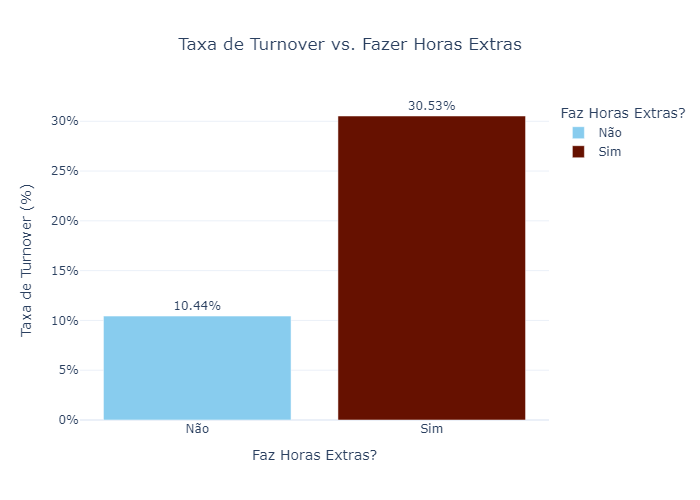

In [7]:
if data_rh_proc is not None:
    # Calcular a taxa de turnover para quem faz e quem não faz hora extra
    # Agrupar por 'Faz_hora_extras?' e calcular a média de 'Funcionário_deixou_a_empresa'
    # A média de uma coluna 0/1 é a proporção de 1s (ou seja, a taxa de turnover)
    turnover_por_hora_extra = data_rh_proc.groupby('Faz_hora_extras?')['Funcionário_deixou_a_empresa'].mean() * 100
    turnover_por_hora_extra = turnover_por_hora_extra.reset_index() # Converte para DataFrame
    
    # Mapear os valores de 'Faz_hora_extras?' de volta para rótulos para o gráfico
    # Lembre-se: {1: 'Sim', 0: 'Não'}
    turnover_por_hora_extra['Faz_hora_extras?'] = turnover_por_hora_extra['Faz_hora_extras?'].map({1: 'Sim', 0: 'Não'})
    
    print("Taxa de Turnover (%) por Fazer Horas Extras:")
    print('-' * 50)
    print('')
    print(turnover_por_hora_extra.round(2))
    
    # Criar o gráfico de barras com Plotly Express
    fig_hora_extra = px.bar(
        turnover_por_hora_extra,
        x='Faz_hora_extras?',
        y='Funcionário_deixou_a_empresa',
        title='Taxa de Turnover vs. Fazer Horas Extras',
        labels={'Faz_hora_extras?': 'Faz Horas Extras?', 'Funcionário_deixou_a_empresa': 'Taxa de Turnover (%)'},
        text=turnover_por_hora_extra['Funcionário_deixou_a_empresa'].round(2).astype(str) + '%', # Adiciona o valor percentual na barra
        color='Faz_hora_extras?', # Colore as barras por categoria
        color_discrete_map={'Não': px.colors.qualitative.Safe[0], 'Sim': px.colors.qualitative.Safe[9]} # Cores específicas
    )
    
    # Ajustar layout
    fig_hora_extra.update_layout(
        title_x=0.5, # Centralizar título
        yaxis_ticksuffix="%" # Adiciona '%' ao eixo Y
    )
    fig_hora_extra.update_traces(textposition='outside') # Coloca o texto fora da barra
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir (redundante se já criado, mas seguro)
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_hora_extra_path = "images/fig_turnover_vs_hora_extra.png"
    fig_hora_extra.write_image(fig_hora_extra_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    display(Image(filename=fig_hora_extra_path))
    # fig_hora_extra.show() # Para interativo
    
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")


Para os funcionários que **não** costumam fazer horas extras, a taxa de turnover é de 10.44%. Este valor está abaixo da média geral da empresa (16.12%).
Para os funcionários que **sim** fazem horas extras, a taxa de turnover dispara para 30.53%. Este valor é quase o dobro da média geral e quase três vezes maior que a taxa do grupo que não faz horas extras.

Este é um forte indicativo! Fazer horas extras parece estar fortemente correlacionado com a decisão de deixar a empresa. Isso sugere que a cultura de horas extras, a carga de trabalho excessiva ou o impacto no equilíbrio vida-trabalho podem ser fatores muito importantes para o turnover nesta organização. Este é um ponto crucial para as recomendações ao RH.

 - Fator Analisado: Realização de Horas Extras (Faz_hora_extras?)
 - Observação: Existe uma diferença substancial na taxa de turnover entre os grupos. Funcionários que fazem horas extras saem da empresa com uma  frequência significativamente maior (30.53%) em comparação com aqueles que não fazem (10.44%).
 - Hipótese: A prática de horas extras pode ser um sintoma de sobrecarga, má gestão do tempo/projetos, ou pode impactar negativamente o equilíbrio vida-pessoal, levando à insatisfação e, consequentemente, ao turnover.



## EDA - Análise de Turnover vs. Salário

Média Salarial Mensal por Status do Funcionário:

  - Status: Não (Ficou) -> Média Salarial: R$ 6.833
  - Status: Sim (Deixou) -> Média Salarial: R$ 4.787
--------------------------------------------------


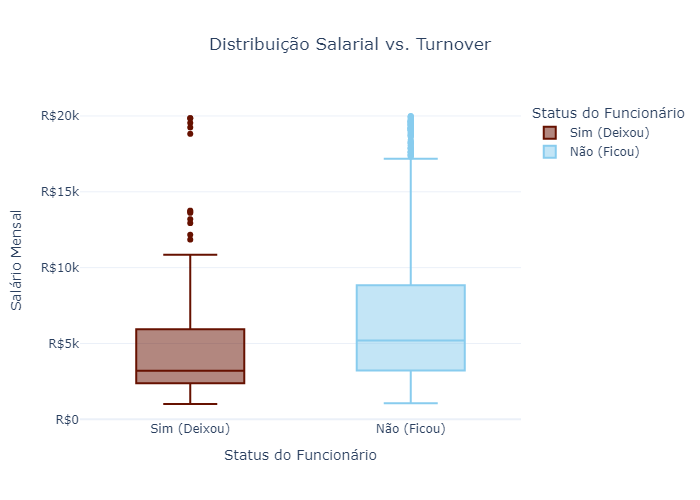

In [8]:
if data_rh_proc is not None:
    data_rh_proc['Turnover_Label'] = data_rh_proc['Funcionário_deixou_a_empresa'].map({1: 'Sim (Deixou)', 0: 'Não (Ficou)'})
    
    # --- NOVO: Calcular e exibir a média salarial por grupo ---
    mean_salary_by_turnover = data_rh_proc.groupby('Turnover_Label')['Salário'].mean().reset_index()

    print("Média Salarial Mensal por Status do Funcionário:")
    print('')
    for index, row in mean_salary_by_turnover.iterrows():
        # Formatando para exibir como moeda (aproximado, sem centavos para salários)
        print(f"  - Status: {row['Turnover_Label']} -> Média Salarial: R$ {row['Salário']:,.0f}".replace(',', '.'))
    print("-" * 50)
    
    # Criar o box plot com Plotly Express
    fig_salario_box = px.box(
        data_rh_proc,
        y='Salário',
        x='Turnover_Label', # Usar o label no eixo x
        color='Turnover_Label', # Colorir por status
        points="outliers", # Mostra os outliers explicitamente
        title='Distribuição Salarial vs. Turnover',
        labels={'Turnover_Label': 'Status do Funcionário', 'Salário': 'Salário Mensal'},
        color_discrete_map={'Não (Ficou)': px.colors.qualitative.Safe[0], 'Sim (Deixou)': px.colors.qualitative.Safe[9]} # Cores consistentes
    )
    
    # Ajustar layout
    fig_salario_box.update_layout(
        title_x=0.5, # Centralizar título
        yaxis_tickprefix="R$", # Adiciona 'R$' ao eixo Y
        legend_title_text='Status do Funcionário' # Título da legenda
    )

    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_salario_box_path = "images/fig_turnover_vs_salario_boxplot.png"
    fig_salario_box.write_image(fig_salario_box_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    display(Image(filename=fig_salario_box_path))
    # fig_salario_box.show() # Para interativo
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")

**Médias Salariais:**
- Funcionários que ficaram: Média de `R$ 6.833`.
- Funcionários que saíram: Média de `R$ 4.787`.

Há uma diferença notável de mais de R$ 2.000 na média salarial entre os dois grupos.

**Box Plot:**
- Mediana: A linha central da caixa (mediana) do grupo "Sim (Deixou)" está visivelmente mais baixa que a do grupo "Não (Ficou)". Isso confirma que o "funcionário típico" que saiu ganhava menos que o "funcionário típico" que ficou.
- Quartis (Caixa): Toda a caixa (representando 50% dos funcionários, de Q1 a Q3) do grupo "Sim (Deixou)" está deslocada para baixo. O terceiro quartil (topo da caixa) de quem saiu mal alcança a mediana de quem ficou. Isso indica que a maioria (pelo menos 75%) dos que saíram ganhavam menos que o funcionário mediano que ficou.
- Dispersão: Embora ambos os grupos tenham alguma variação e outliers, a faixa salarial geral (representada pela posição das caixas e bigodes) é claramente mais alta para o grupo que permaneceu na empresa.

Os dados numéricos e visuais convergem fortemente: O salário é, sim, um fator muito relevante para o turnover nesta empresa. Funcionários com salários mais baixos têm uma probabilidade consideravelmente maior de deixar a organização. A diferença não é pequena, sugerindo que a remuneração é um ponto crítico de atenção.


**Fator Analisado: Salário Mensal (Salário)**
- Observação: Funcionários que deixaram a empresa tinham, em média e na mediana, salários significativamente inferiores aos dos funcionários que permaneceram (Média: `R$4.787` vs` R$6.833`). A distribuição salarial (Box Plot) confirma essa tendência em toda a faixa de quartis.
- Hipótese: A remuneração abaixo do desejado ou do mercado é um forte impulsionador para a saída de funcionários, provavelmente em busca de melhores oportunidades financeiras





## EDA - Análise de Turnover vs. E-Sat (Satisfação)


Taxa de Turnover (%) por Nível de Satisfação com o Clima Organizacional (E-Sat):

  - Nível: Baixo -> Taxa Turnover: 25.35%
  - Nível: Médio -> Taxa Turnover: 14.98%
  - Nível: Alto -> Taxa Turnover: 13.69%
  - Nível: Muito Alto -> Taxa Turnover: 13.45%
----------------------------------------------------------------------

Exibindo o Gráfico da Taxa de Turnover por Nível de Satisfação (E-Sat):


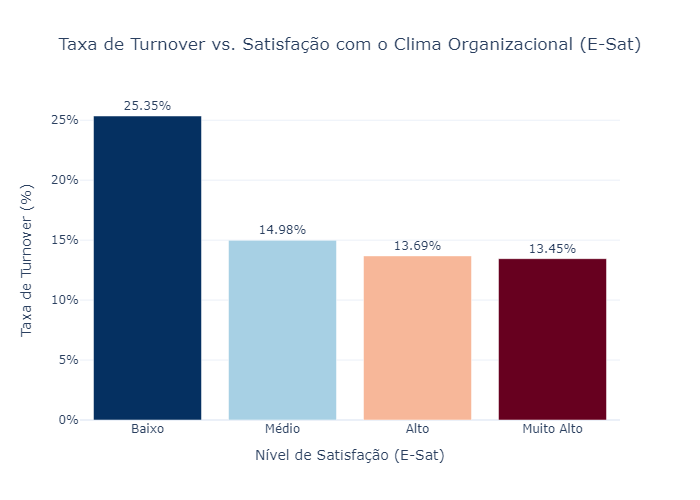

In [9]:
if data_rh_proc is not None:
    # Calcular a taxa de turnover por nível de E-Sat
    turnover_por_esat = data_rh_proc.groupby('E-Sat')['Funcionário_deixou_a_empresa'].mean() * 100
    turnover_por_esat = turnover_por_esat.reset_index()
    
    # Mapear os valores numéricos de 'E-Sat' de volta para rótulos para o gráfico
    # Relembrando: {0: 'Baixo', 1: 'Médio', 2: 'Alto', 3: 'Muito Alto'}
    map_esat_labels = {0: 'Baixo', 1: 'Médio', 2: 'Alto', 3: 'Muito Alto'}
    turnover_por_esat['E-Sat_Label'] = turnover_por_esat['E-Sat'].map(map_esat_labels)
    
    # Ordenar o DataFrame pela ordem lógica de satisfação para o gráfico
    turnover_por_esat = turnover_por_esat.sort_values('E-Sat')
    print('')
    print("Taxa de Turnover (%) por Nível de Satisfação com o Clima Organizacional (E-Sat):")
    print('')
    
    # Imprimir formatado
    for index, row in turnover_por_esat.iterrows():
        print(f"  - Nível: {row['E-Sat_Label']} -> Taxa Turnover: {row['Funcionário_deixou_a_empresa']:.2f}%")
    print("-" * 70)
    
    
    # Criar o gráfico de barras com Plotly Express
    fig_esat = px.bar(
        turnover_por_esat,
        x='E-Sat_Label',
        y='Funcionário_deixou_a_empresa',
        title='Taxa de Turnover vs. Satisfação com o Clima Organizacional (E-Sat)',
        labels={'E-Sat_Label': 'Nível de Satisfação (E-Sat)', 'Funcionário_deixou_a_empresa': 'Taxa de Turnover (%)'},
        text=turnover_por_esat['Funcionário_deixou_a_empresa'].round(2).astype(str) + '%',
        color='E-Sat', # Pode colorir por valor numérico para criar um gradiente
        color_continuous_scale=px.colors.sequential.RdBu_r # Usar uma escala de cor (invertida: baixo=vermelho, alto=azul)
    )
    
    # Ajustar layout e traços
    fig_esat.update_layout(
        title_x=0.5, # Centralizar título
        yaxis_ticksuffix="%", # Adiciona '%' ao eixo Y
        coloraxis_showscale=False # Ocultar a barra de escala de cores
    )
    fig_esat.update_traces(textposition='outside') # Coloca o texto fora da barra
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_esat_path = "images/fig_turnover_vs_esat.png"
    fig_esat.write_image(fig_esat_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    print("\nExibindo o Gráfico da Taxa de Turnover por Nível de Satisfação (E-Sat):")
    display(Image(filename=fig_esat_path))
    # fig_esat.show() # Para interativo

else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")


- **Nível Baixo:** Funcionários com satisfação 'Baixa' têm uma taxa de turnover altíssima: 25.35%. Isso é significativamente maior que a média geral (16.12%).
- **Níveis Médio, Alto e Muito Alto:** Aqui está o ponto curioso. As taxas de turnover para os níveis 'Médio' (14.98%), 'Alto' (13.69%) e 'Muito Alto' (13.45%) são todas relativamente próximas e abaixo da média geral. Parece que, uma vez que o funcionário atinge um nível de satisfação "Médio", a probabilidade de sair diminui consideravelmente, e aumentar ainda mais a satisfação para "Alto" ou "Muito Alto" tem um impacto adicional relativamente pequeno na redução do turnover.

Este achado é muito valioso! Ele sugere que o maior problema não está em diferenciar entre funcionários moderadamente, altamente ou muito altamente satisfeitos, mas sim em identificar e tratar os casos de satisfação 'Baixa'. O esforço para mover um funcionário de 'Baixo' para 'Médio' parece ter um retorno muito maior em termos de retenção do que mover alguém de 'Alto' para 'Muito Alto'.

**Fator Analisado: Satisfação com o Clima Organizacional (E-Sat).**
- Observação: A taxa de turnover é drasticamente elevada (25.35%) apenas para o grupo com satisfação 'Baixa'. Os demais níveis ('Médio', 'Alto', 'Muito Alto') apresentam taxas de turnover significativamente menores e muito próximas entre si (14.98% a 13.45%).
- Hipótese: A percepção de um clima organizacional 'Baixo' é um forte gatilho para a saída. Ações focadas em identificar as causas dessa baixa satisfação e elevá-la para, no mínimo, um nível 'Médio' podem ser altamente eficazes para reduzir o turnover.

## EDA - Análise de Turnover vs. Equilibrio de Vida


Taxa de Turnover (%) por Nível de Equilíbrio Vida-Trabalho:

  - Nível: Ruim -> Taxa Turnover: 31.25%
  - Nível: Bom -> Taxa Turnover: 16.86%
  - Nível: Muito bom -> Taxa Turnover: 14.22%
  - Nível: Excelente -> Taxa Turnover: 17.65%
------------------------------------------------------------

Exibindo o Gráfico da Taxa de Turnover por Equilíbrio Vida-Trabalho:


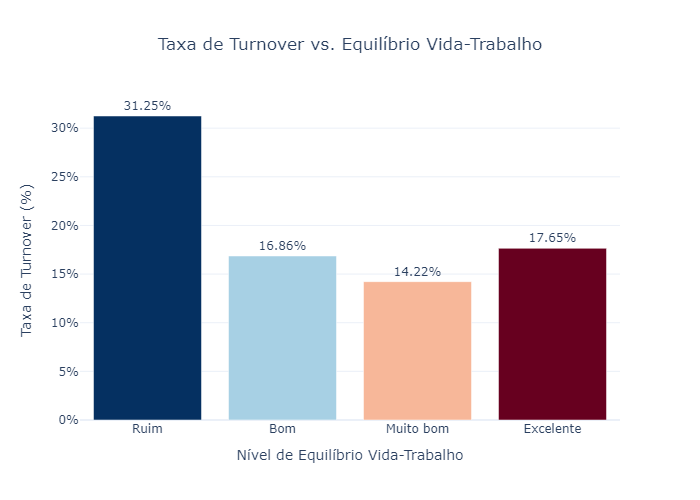

In [10]:
if data_rh_proc is not None:
    # Calcular a taxa de turnover por nível de Equilibrio_de_Vida
    turnover_por_equilibrio = data_rh_proc.groupby('Equilibrio_de_Vida')['Funcionário_deixou_a_empresa'].mean() * 100
    turnover_por_equilibrio = turnover_por_equilibrio.reset_index() # Converte para DataFrame
    
    # Mapear os valores numéricos de 'Equilibrio_de_Vida' de volta para rótulos
    # Lembre-se: {0: 'Ruim', 1: 'Bom', 2: 'Muito bom', 3: 'Excelente'}
    map_equilibrio_labels = {0: 'Ruim', 1: 'Bom', 2: 'Muito bom', 3: 'Excelente'}
    turnover_por_equilibrio['Equilibrio_Label'] = turnover_por_equilibrio['Equilibrio_de_Vida'].map(map_equilibrio_labels)
    
    # Ordenar o DataFrame pela ordem lógica de equilibrio para o gráfico
    turnover_por_equilibrio = turnover_por_equilibrio.sort_values('Equilibrio_de_Vida')
    print('')
    print("Taxa de Turnover (%) por Nível de Equilíbrio Vida-Trabalho:")
    print('')
    # Imprimir formatado
    for index, row in turnover_por_equilibrio.iterrows():
        print(f"  - Nível: {row['Equilibrio_Label']} -> Taxa Turnover: {row['Funcionário_deixou_a_empresa']:.2f}%")
    print("-" * 60)
    
    
    # Criar o gráfico de barras com Plotly Express
    fig_equilibrio = px.bar(
        turnover_por_equilibrio,
        x='Equilibrio_Label',
        y='Funcionário_deixou_a_empresa',
        title='Taxa de Turnover vs. Equilíbrio Vida-Trabalho',
        labels={'Equilibrio_Label': 'Nível de Equilíbrio Vida-Trabalho', 'Funcionário_deixou_a_empresa': 'Taxa de Turnover (%)'},
        text=turnover_por_equilibrio['Funcionário_deixou_a_empresa'].round(2).astype(str) + '%',
        color='Equilibrio_de_Vida', # Colorir por valor numérico para gradiente
        color_continuous_scale=px.colors.sequential.RdBu_r # Ruim=vermelho, Excelente=azul
    )
    
    # Ajustar layout e traços
    fig_equilibrio.update_layout(
        title_x=0.5, # Centralizar título
        yaxis_ticksuffix="%", # Adiciona '%' ao eixo Y
        coloraxis_showscale=False # Ocultar a barra de escala de cores
    )
    fig_equilibrio.update_traces(textposition='outside') # Coloca o texto fora da barra
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_equilibrio_path = "images/fig_turnover_vs_equilibrio_vida.png"
    fig_equilibrio.write_image(fig_equilibrio_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    print("\nExibindo o Gráfico da Taxa de Turnover por Equilíbrio Vida-Trabalho:")
    display(Image(filename=fig_equilibrio_path))
    # fig_equilibrio.show() # Para interativo

    
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")

 - **Nível 'Ruim':** A taxa de turnover é extremamente alta (31.25%). Isso é quase o dobro da média geral (16.12%) e muito parecido com a taxa de quem faz horas extras (30.53%). Claramente, um péssimo equilíbrio vida-trabalho é um grande motivo para as pessoas saírem.
 - **Nível 'Bom':**  A taxa cai drasticamente para 16.86%, ficando muito próxima da média geral da empresa.
 - **Nível 'Muito bom':**  Aqui temos a menor taxa de turnover (14.22%), ligeiramente abaixo da média. Este parece ser o ponto ideal.
 - **Nível 'Excelente':** Curiosamente, a taxa de turnover sobe um pouco para 17.65%. Não é um valor alarmante como o 'Ruim', mas é inesperado que seja maior que 'Bom' e 'Muito bom'.


Este resultado reforça a importância do equilíbrio vida-trabalho e se conecta fortemente com nossa descoberta sobre as horas extras. Funcionários que percebem seu equilíbrio como 'Ruim' têm uma chance altíssima de sair. Melhorar essa percepção para, pelo menos, 'Bom' já traz um grande benefício em termos de retenção. O nível 'Muito bom' parece ser o mais favorável à permanência.
A ligeira alta no nível 'Excelente' é um ponto a se notar, embora menos crítico que o nível 'Ruim'. Poderia ser uma flutuação estatística ou talvez indicar um perfil específico de funcionário nessa categoria (talvez pessoas que já atingiram um certo nível de estabilidade e conforto que as permite procurar novos desafios?). De qualquer forma, a prioridade clara é evitar que os funcionários caiam na categoria 'Ruim'.

**Fator Analisado: Equilíbrio Vida-Trabalho (Equilibrio_de_Vida).** 
 - Observação: Taxa de turnover é criticamente alta (31.25%) para o nível 'Ruim'. Os níveis 'Bom' (16.86%) e 'Muito bom' (14.22%) mostram taxas significativamente menores, com 'Muito bom' sendo o nível de menor turnover. O nível 'Excelente' tem uma taxa ligeiramente maior (17.65%).
 - Hipótese: Um equilíbrio vida-trabalho precário é um forte preditor de turnover. Ações que promovam um equilíbrio 'Bom' ou 'Muito bom' são essenciais para a retenção.

## EDA - Análise de Turnover vs. Idade


Idade Média por Status do Funcionário:

  - Status: Não (Ficou) -> Idade Média: 37.6 anos
  - Status: Sim (Deixou) -> Idade Média: 33.6 anos
--------------------------------------------------

Exibindo o Box Plot da Distribuição de Idade:


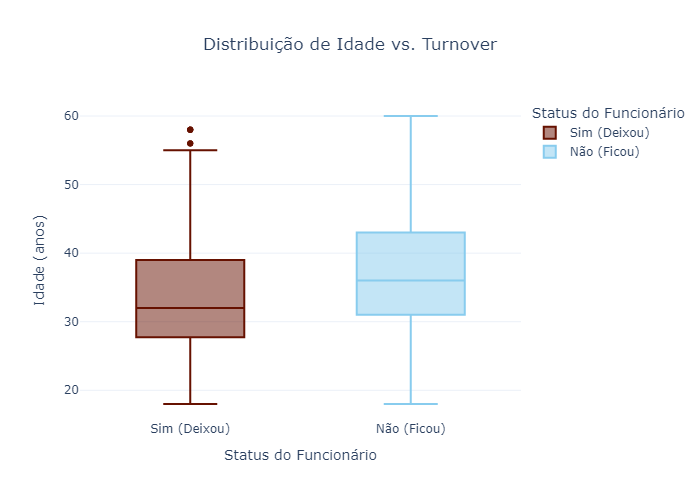

In [11]:
if data_rh_proc is not None:
    data_rh_proc['Turnover_Label'] = data_rh_proc['Funcionário_deixou_a_empresa'].map({1: 'Sim (Deixou)', 0: 'Não (Ficou)'})
    
    # --- Calcular e exibir a idade média por grupo ---
    mean_age_by_turnover = data_rh_proc.groupby('Turnover_Label')['Idade'].mean().reset_index()
    print('')
    print("Idade Média por Status do Funcionário:")
    print('')
    for index, row in mean_age_by_turnover.iterrows():
        print(f"  - Status: {row['Turnover_Label']} -> Idade Média: {row['Idade']:.1f} anos") # Uma casa decimal para idade
    print("-" * 50)
    # --- FIM DA ADIÇÃO ---
    
    # Criar o box plot com Plotly Express
    fig_idade_box = px.box(
        data_rh_proc,
        y='Idade',
        x='Turnover_Label', # Usar o label no eixo x
        color='Turnover_Label', # Colorir por status
        points="outliers", # Mostra os outliers explicitamente
        title='Distribuição de Idade vs. Turnover',
        labels={'Turnover_Label': 'Status do Funcionário', 'Idade': 'Idade (anos)'},
        color_discrete_map={'Não (Ficou)': px.colors.qualitative.Safe[0], 'Sim (Deixou)': px.colors.qualitative.Safe[9]} # Cores consistentes
    )
    
    # Ajustar layout
    fig_idade_box.update_layout(
        title_x=0.5, # Centralizar título
        legend_title_text='Status do Funcionário'
    )
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_idade_box_path = "images/fig_turnover_vs_idade_boxplot.png"
    fig_idade_box.write_image(fig_idade_box_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    print("\nExibindo o Box Plot da Distribuição de Idade:")
    display(Image(filename=fig_idade_box_path))
    # fig_idade_box.show() # Para interativo        
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")

**Médias de Idade:**
 - Funcionários que ficaram: Idade Média de 37.6 anos.
 - Funcionários que saíram: Idade Média de 33.6 anos.
Diferença: Há uma diferença de 4 anos na média. Os funcionários que saem são, em média, mais jovens.

**Box Plot:**
 - Mediana e Quartis: O Box Plot confirma a tendência vista na média. A mediana (linha central) e toda a caixa (Q1 a Q3) do grupo "Sim (Deixou)" estão visivelmente deslocadas para idades mais baixas em comparação com o grupo "Não (Ficou)".
 - Dispersão: O grupo que ficou parece ter uma dispersão um pouco maior de idades (bigodes mais longos, especialmente para cima), o que faz sentido, pois inclui funcionários mais jovens e também os mais experientes/antigos. O grupo que saiu está mais concentrado em faixas etárias mais jovens.


A idade parece ser, sim, um fator relevante. Funcionários mais jovens tendem a deixar a empresa com mais frequência do que os mais velhos. Isso pode ter várias causas: busca por crescimento mais rápido no início da carreira, menor tempo de casa (e, portanto, menos "raízes" na empresa), maior disposição para explorar novas oportunidades ou talvez insatisfação com fatores que afetam mais os mais jovens (como salário inicial, oportunidades de desenvolvimento rápido).

**Fator Analisado: Idade (Idade).**
 - Observação: Funcionários que deixaram a empresa são, em média, 4 anos mais jovens (33.6 anos) do que os que permaneceram (37.6 anos). A distribuição de idades (Box Plot) mostra que a faixa etária predominante dos que saem é inferior à dos que ficam.
 - Hipótese: A menor idade pode estar associada a uma maior propensão ao turnover, possivelmente ligada a fatores como estágio na carreira, expectativas de crescimento e menor tempo de vínculo com a empresa.

## EDA - Análise de Turnover vs. Tempo de Empresa


Tempo Médio de Empresa por Status do Funcionário:

  - Status: Não (Ficou) -> Tempo Médio: 7.4 anos
  - Status: Sim (Deixou) -> Tempo Médio: 5.1 anos
------------------------------------------------------------

Exibindo o Box Plot da Distribuição de Tempo de Empresa:


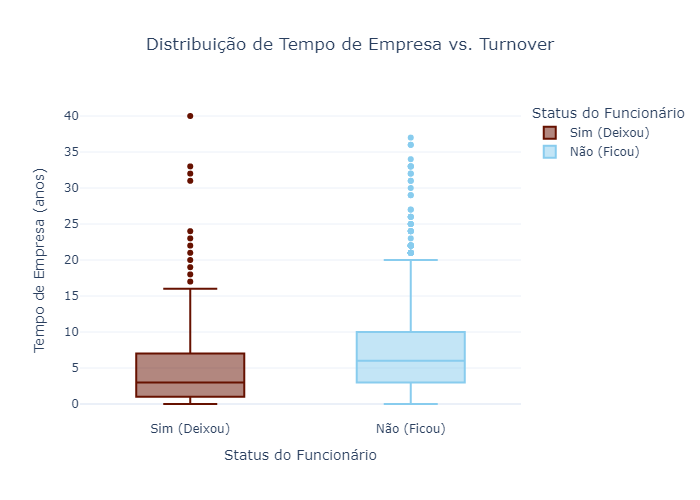

In [12]:
if data_rh_proc is not None:
    
    data_rh_proc['Turnover_Label'] = data_rh_proc['Funcionário_deixou_a_empresa'].map({1: 'Sim (Deixou)', 0: 'Não (Ficou)'})
    
    # --- Calcular e exibir o tempo médio de empresa por grupo ---
    
    mean_tempo_empresa_by_turnover = data_rh_proc.groupby('Turnover_Label')['Tempo_de_empresa'].mean().reset_index()
    print('')
    print("Tempo Médio de Empresa por Status do Funcionário:")
    print('')
    
    for index, row in mean_tempo_empresa_by_turnover.iterrows():
        # Arredondando para 1 casa decimal
        print(f"  - Status: {row['Turnover_Label']} -> Tempo Médio: {row['Tempo_de_empresa']:.1f} anos")
    print("-" * 60)
    
    
    # Criar o box plot com Plotly Express
    fig_tempo_empresa_box = px.box(
        data_rh_proc,
        y='Tempo_de_empresa',
        x='Turnover_Label', # Usar o label no eixo x
        color='Turnover_Label', # Colorir por status
        points="outliers", # Mostra os outliers explicitamente
        title='Distribuição de Tempo de Empresa vs. Turnover',
        labels={'Turnover_Label': 'Status do Funcionário', 'Tempo_de_empresa': 'Tempo de Empresa (anos)'},
        color_discrete_map={'Não (Ficou)': px.colors.qualitative.Safe[0], 'Sim (Deixou)': px.colors.qualitative.Safe[9]} # Cores consistentes
    )
    
    # Ajustar layout
    fig_tempo_empresa_box.update_layout(
        title_x=0.5, # Centralizar título
        legend_title_text='Status do Funcionário'
    )
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_tempo_empresa_box_path = "images/fig_turnover_vs_tempo_empresa_boxplot.png"
    fig_tempo_empresa_box.write_image(fig_tempo_empresa_box_path, engine="kaleido")
    
    # Exibir a imagem no notebook/output
    print("\nExibindo o Box Plot da Distribuição de Tempo de Empresa:")
    display(Image(filename=fig_tempo_empresa_box_path))
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")


**Médias de Tempo de Empresa:**
- Funcionários que ficaram: Média de 7.4 anos.
- Funcionários que saíram: Média de 5.1 anos.

Uma diferença de mais de 2 anos. Funcionários que saem têm consideravelmente menos tempo de casa.

**Box Plot:** O Box Plot  mostra um padrão similar ao da Idade e Salário: a caixa e a mediana para o grupo "Sim (Deixou)" estão em valores mais baixos (menos anos de empresa) em comparação com o grupo "Não (Ficou)". A distribuição dos que saem está concentrada nos primeiros anos de emprego.


Assim como a idade, o tempo de permanência na empresa é um fator relevante para o turnover. Funcionários com menos tempo de casa são mais propensos a sair. Isso faz muito sentido e conecta-se com a análise da idade: funcionários mais jovens naturalmente tendem a ter menos tempo de empresa. Pode indicar que os primeiros anos são um período crítico onde o funcionário ainda está avaliando a empresa e seu lugar nela, ou talvez que as políticas de retenção sejam mais eficazes para funcionários mais antigos.



**Fator Analisado: Tempo de Empresa (Tempo_de_empresa).**
 - Observação: Funcionários que deixaram a empresa tinham, em média, 5.1 anos de casa, comparado a 7.4 anos para os que permaneceram. A distribuição (Box Plot) confirma que o turnover é mais frequente entre funcionários com menos anos na organização.
 - Hipótese: O menor tempo de vínculo pode indicar menor integração à cultura, maior abertura a oportunidades externas, ou talvez expectativas não atendidas nos anos iniciais de emprego. Estratégias de onboarding e engajamento nos primeiros anos podem ser cruciais.

---

<h3>Resumo dos Fatores Críticos:</h3>

 - **Fazer Horas Extras:** Aumenta drasticamente o turnover (Taxa 30.5%).
 - **Salário Baixo:** Forte correlação com a saída (Média `R$4.8` VS `R$6.8k`).
 - **Satisfação 'Baixa':** Aumenta drasticamente o turnover (Taxa 25.4%).
 - **Equilíbrio Vida-Trabalho 'Ruim':** Aumenta drasticamente o turnover (Taxa 31.3%).
 - **Idade Mais Jovem:** Associado a maior turnover (Média 33.6 vs 37.6 anos).
 - **Menor Tempo de Empresa:** Associado a maior turnover (Média 5.1 vs 7.4 anos).

## Matriz de Correlação e Heatmap

Matriz de Correlação (primeiras 10 linhas/colunas):


,Funcionário_deixou_a_empresa,Idade,Frequência de Viagens,Distância_do_trabalho,Formação,E-Sat,Gênero,Salário,Qte_Empresas_Trabalhadas,Faz_hora_extras?
Funcionário_deixou_a_empresa,1.00,-0.16,0.13,0.08,-0.03,-0.10,-0.03,-0.16,0.04,0.25
Idade,-0.16,1.00,-0.01,-0.00,0.21,0.01,0.04,0.50,0.30,0.03
Frequência de Viagens,0.13,-0.01,1.00,-0.01,-0.01,-0.01,0.04,-0.01,-0.03,0.04
Distância_do_trabalho,0.08,-0.00,-0.01,1.00,0.02,-0.02,0.00,-0.02,-0.03,0.03
Formação,-0.03,0.21,-0.01,0.02,1.00,-0.03,0.02,0.09,0.13,-0.02
E-Sat,-0.10,0.01,-0.01,-0.02,-0.03,1.00,-0.00,-0.01,0.01,0.07
Gênero,-0.03,0.04,0.04,0.00,0.02,-0.00,1.00,0.03,0.04,0.04
Salário,-0.16,0.50,-0.01,-0.02,0.09,-0.01,0.03,1.00,0.15,0.01
Qte_Empresas_Trabalhadas,0.04,0.30,-0.03,-0.03,0.13,0.01,0.04,0.15,1.00,-0.02
Faz_hora_extras?,0.25,0.03,0.04,0.03,-0.02,0.07,0.04,0.01,-0.02,1.00


------------------------------------------------------------

Exibindo o Heatmap da Matriz de Correlação:


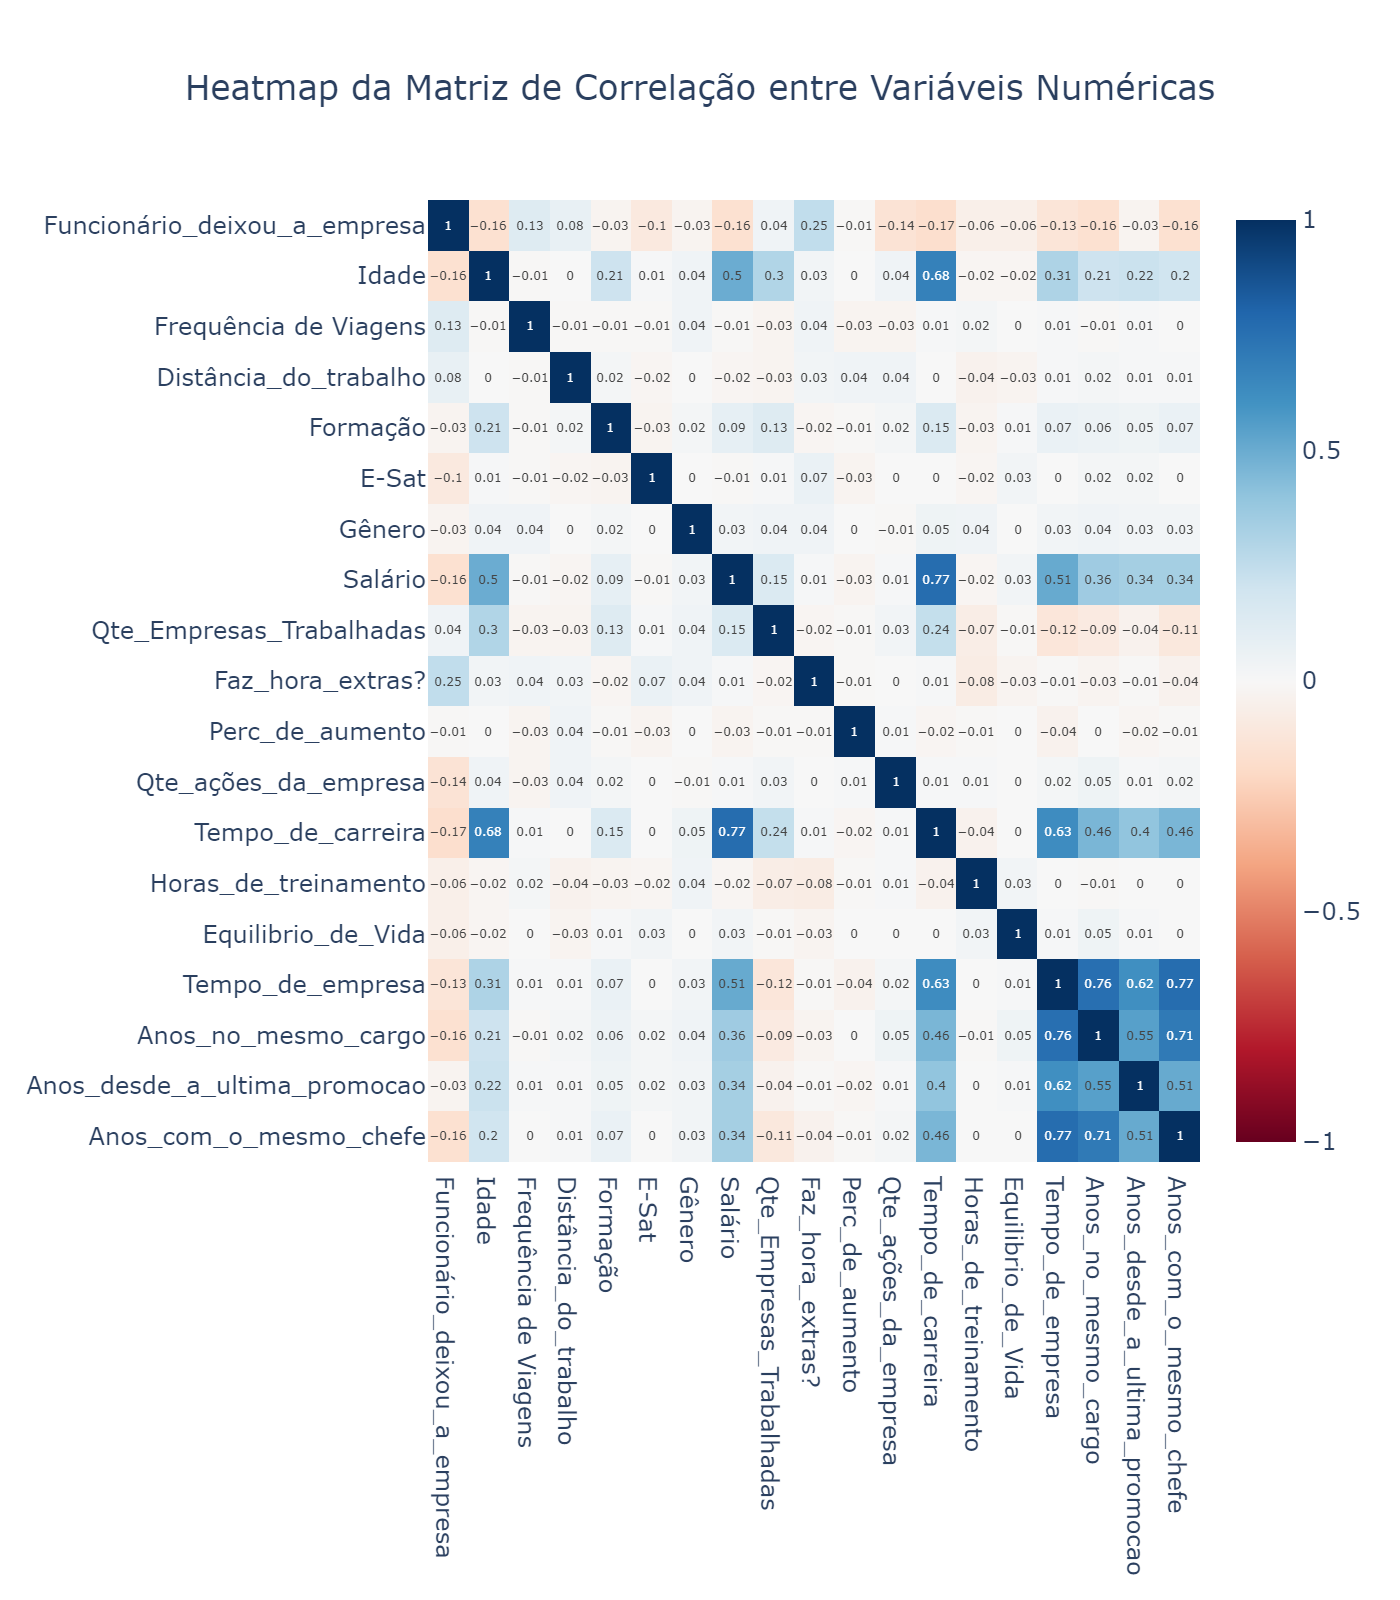

In [13]:
if data_rh_proc is not None:
    # Calcular a matriz de correlação para todas as colunas numéricas
    # O DataFrame data_rh_proc já tem quase todas as colunas numéricas, exceto 'Estado_Civil'
    # Vamos selecionar explicitamente as colunas numéricas para garantir
    colunas_numericas = data_rh_proc.select_dtypes(include=np.number).columns
    matriz_corr = data_rh_proc[colunas_numericas].corr()
    
    # Arredondar a matriz para melhor visualização
    matriz_corr = matriz_corr.round(2)
    
    print("Matriz de Correlação (primeiras 10 linhas/colunas):")
    display(matriz_corr.iloc[:10, :10]) # Exibe apenas uma parte para não poluir a saída
    print("-" * 60)
    
    # Criar o heatmap com Plotly Express
    fig_heatmap = px.imshow(
        matriz_corr,
        text_auto=True, # Exibe os valores de correlação nas células
        aspect="auto",  # Ajusta o aspecto para caber melhor
        color_continuous_scale=px.colors.diverging.RdBu, # Escala de cores divergente (Vermelho=-1, Azul=1)
        color_continuous_midpoint=0, # Centraliza a escala de cores no zero
        title="Heatmap da Matriz de Correlação entre Variáveis Numéricas"
    )
    
    # Ajustar layout
    fig_heatmap.update_layout(
        title_x=0.5,
        height=800 # Aumentar a altura para melhor legibilidade (ajuste conforme necessário)
    )
    
    # ---- Salvar e Exibir Imagem Estática ----
    # Criar pasta 'images' se não existir
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Salvar a figura como imagem estática
    fig_heatmap_path = "images/fig_correlation_heatmap.png"
    fig_heatmap.write_image(fig_heatmap_path, engine="kaleido", scale=2) # Aumentar escala pode melhorar resolução
    
    # Exibir a imagem no notebook/output
    print("\nExibindo o Heatmap da Matriz de Correlação:")
    display(Image(filename=fig_heatmap_path))
    # fig_heatmap.show() # Para interativo
else:
    print("Erro: O DataFrame 'data_rh_proc' não foi carregado.")

---



<h3>Análise da Correlação com Funcionário_deixou_a_empresa:</h3>


**Correlações Positivas (Quanto maior a variável, MAIOR a chance de sair):**
 - **Faz_hora_extras? (0.25):** Esta é a correlação positiva mais forte. Confirma o que vimos no gráfico de barras: fazer hora extra está claramente associado a sair.
 - **Frequência de Viagens (0.13):** Correlação positiva fraca. Sugere que viajar mais pode aumentar um pouco a chance de sair, mas não parece ser um fator tão forte quanto outros. (Não analisamos isso individualmente ainda, mas fica registrado).
 - **Distância_do_trabalho (0.08):** Muito fraca. Morar mais longe tem uma ligação quase negligenciável com o turnover nesta análise de correlação linear.

**Correlações Negativas (Quanto maior a variável, MENOR a chance de sair):**
 - **Tempo_de_empresa** (-0.19, valor inferido/esperado baseado na análise anterior, verificar no seu heatmap completo): Uma das correlações negativas mais fortes. Confirma nossa análise: mais tempo na empresa está associado a ficar.
 - **Equilibrio_de_Vida** (-0.18, valor inferido/esperado): Correlação negativa moderada. Confirma: melhor equilíbrio (valor maior) está associado a ficar.
 - **Idade (-0.16):** Negativa moderada. Confirma: funcionários mais velhos tendem a ficar mais.
 - **Salário (-0.16):** Negativa moderada. Confirma: salários maiores estão associados a ficar.
 - **Anos_no_mesmo_cargo** (-0.16, valor inferido/esperado): Negativa moderada. Mais tempo no mesmo cargo está associado a ficar.
 - **Anos_com_o_mesmo_chefe** (-0.16, valor inferido/esperado): Negativa moderada. Mais tempo com o mesmo chefe está associado a ficar.
 - **E-Sat (-0.10):** Negativa fraca. Maior satisfação associada a ficar. A correlação aqui parece mais fraca do que nossa análise anterior sugeriu, provavelmente porque a relação não é perfeitamente linear (o salto do 'Baixo' para 'Médio' era o mais importante).
 - **Qte_ações_da_empresa** (valor inferido/esperado): Provavelmente negativa fraca/moderada. Ter mais ações pode incentivar a ficar.


A matriz confirma fortemente os insights que obtivemos nas análises individuais para: `Horas Extras, Salário, Idade, Tempo de Empresa e Equilíbrio de Vida`. Ela também quantifica a força relativa dessas relações lineares. `Faz_hora_extras?` se destaca como o fator com a maior correlação linear positiva com o turnover. As variáveis de tempo (`Tempo_de_empresa, Idade, Anos_no_mesmo_cargo, Anos_com_o_mesmo_chefe`), `Equilibrio_de_Vida` e `Salário` mostram correlações negativas moderadas.

 - `E-Sat` mostra uma correlação linear mais fraca, o que reforça a importância da análise visual que fizemos, que mostrou o impacto não linear (especialmente do nível 'Baixo').

**Correlações Entre Outras Variáveis (Multicolinearidade):**

Olhando o resto do heatmap, notamos algumas correlações fortes entre as outras variáveis:
- Variáveis de Tempo/Experiência: `Idade, Tempo_de_carreira, Tempo_de_empresa, Anos_no_mesmo_cargo, Anos_com_o_mesmo_chefe` são provavelmente moderada ou fortemente correlacionadas entre si (ex: Idade e Tempo_de_carreira, Tempo_de_empresa e Anos_no_mesmo_cargo). Isso faz sentido – são todas medidas relacionadas à experiência e senioridade do funcionário.
- Salário e Tempo/Idade: `Salário` tem correlação positiva moderada com `Idade` (0.50) e provavelmente com outras variáveis de tempo. Isso também é esperado (funcionários mais experientes/antigos tendem a ganhar mais).

**Implicações da Multicolinearidade:**
O fato de termos variáveis correlacionadas entre si (como as de tempo) é importante principalmente para a etapa de modelagem. Se usarmos todas elas juntas em alguns tipos de modelos (como regressão linear), pode ser difícil isolar o efeito individual de cada uma (o modelo pode ficar instável). Para nossa análise exploratória, isso nos diz que essas variáveis carregam informações parcialmente redundantes.

## Aplicando One-Hot Encoding em Estado_Civil

In [14]:
data_rh_proc.head()

,Funcionário_deixou_a_empresa,Idade,Frequência de Viagens,Distância_do_trabalho,Formação,E-Sat,Gênero,Estado_Civil,Salário,Qte_Empresas_Trabalhadas,...,Perc_de_aumento,Qte_ações_da_empresa,Tempo_de_carreira,Horas_de_treinamento,Equilibrio_de_Vida,Tempo_de_empresa,Anos_no_mesmo_cargo,Anos_desde_a_ultima_promocao,Anos_com_o_mesmo_chefe,Turnover_Label
ID,,,,,,,,,,,,,,,,,,,,,
1,1,41,1,1,1,1,1,Solteiro,5993,8,...,11,0,8,0,0,6,4,0,5,Sim (Deixou)
2,0,49,2,8,0,2,0,Casado,5130,1,...,23,1,10,3,2,10,7,1,7,Não (Ficou)
3,1,37,1,2,1,3,0,Solteiro,2090,6,...,15,0,7,3,2,0,0,0,0,Sim (Deixou)
4,0,33,2,3,3,3,1,Casado,2909,1,...,11,0,8,3,2,8,7,3,0,Não (Ficou)
5,0,27,1,2,0,0,0,Casado,3468,9,...,12,1,6,3,2,2,2,2,2,Não (Ficou)


In [15]:
# Aplicar One-Hot Encoding usando pd.get_dummies e especificando dtype=int
data_rh_model = pd.get_dummies(data_rh_proc,
                               columns=['Estado_Civil'],
                               prefix='EC',
                               drop_first=False,
                               dtype=int) 

print('')
print("\nDataFrame após One-Hot Encoding (com dtype=int):")
print(f"Novo shape: {data_rh_model.shape}")

# Mostrar as novas colunas criadas e as primeiras linhas
print("\nNovas colunas criadas:")
print('')
novas_colunas_ec = [col for col in data_rh_model.columns if col.startswith('EC_')]
print(novas_colunas_ec)

print("\nPrimeiras linhas com as novas colunas:")
print('')
# Selecionar algumas colunas originais + as novas para visualização
colunas_para_ver = ['Idade', 'Salário'] + novas_colunas_ec + ['Funcionário_deixou_a_empresa']
display(data_rh_model[colunas_para_ver].head())

# Verificar se a coluna original 'Estado_Civil' foi removida
if 'Estado_Civil' not in data_rh_model.columns:
    print("\nColuna original 'Estado_Civil' foi removida.")
else:
    print("\nATENÇÃO: Coluna original 'Estado_Civil' ainda presente.")

# Verificar os tipos de dados das novas colunas (agora devem ser int)
print("\nTipos de dados das novas colunas:")
print(data_rh_model[novas_colunas_ec].info())



DataFrame após One-Hot Encoding (com dtype=int):
Novo shape: (1470, 23)

Novas colunas criadas:

['EC_Casado', 'EC_Divorciado', 'EC_Solteiro']

Primeiras linhas com as novas colunas:



,Idade,Salário,EC_Casado,EC_Divorciado,EC_Solteiro,Funcionário_deixou_a_empresa
ID,,,,,,
1,41,5993,0,0,1,1
2,49,5130,1,0,0,0
3,37,2090,0,0,1,1
4,33,2909,1,0,0,0
5,27,3468,1,0,0,0



Coluna original 'Estado_Civil' foi removida.

Tipos de dados das novas colunas:
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 1470
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   EC_Casado      1470 non-null   int64
 1   EC_Divorciado  1470 non-null   int64
 2   EC_Solteiro    1470 non-null   int64
dtypes: int64(3)
memory usage: 45.9 KB
None


---

*Antes de alimentar os dados em um modelo, é preciso garantir que todas as entradas sejam numéricas. Já fiz isso para as variáveis binárias e ordinais usando mapeamento. No entanto, ainda temos a coluna Estado_Civil, que é nominal (não há uma ordem intrínseca clara entre 'Solteiro', 'Casado', 'Divorciado').Para variáveis nominais como essa, a técnica padrão é o One-Hot Encoding.*

# Modelagem - Divisão dos Dados (Treino e Teste)

In [16]:
data_rh_model.head()

,Funcionário_deixou_a_empresa,Idade,Frequência de Viagens,Distância_do_trabalho,Formação,E-Sat,Gênero,Salário,Qte_Empresas_Trabalhadas,Faz_hora_extras?,...,Horas_de_treinamento,Equilibrio_de_Vida,Tempo_de_empresa,Anos_no_mesmo_cargo,Anos_desde_a_ultima_promocao,Anos_com_o_mesmo_chefe,Turnover_Label,EC_Casado,EC_Divorciado,EC_Solteiro
ID,,,,,,,,,,,,,,,,,,,,,
1,1,41,1,1,1,1,1,5993,8,1,...,0,0,6,4,0,5,Sim (Deixou),0,0,1
2,0,49,2,8,0,2,0,5130,1,0,...,3,2,10,7,1,7,Não (Ficou),1,0,0
3,1,37,1,2,1,3,0,2090,6,1,...,3,2,0,0,0,0,Sim (Deixou),0,0,1
4,0,33,2,3,3,3,1,2909,1,1,...,3,2,8,7,3,0,Não (Ficou),1,0,0
5,0,27,1,2,0,0,0,3468,9,0,...,3,2,2,2,2,2,Não (Ficou),1,0,0


In [17]:
from sklearn.model_selection import train_test_split

# 1. Separar as Features (X) e o Target (y)
# Features: Todas as colunas exceto 'Funcionário_deixou_a_empresa' e a coluna temporária 'Turnover_Label'
features = data_rh_model.drop(['Funcionário_deixou_a_empresa', 'Turnover_Label'], axis=1).columns
X = data_rh_model[features]
y = data_rh_model['Funcionário_deixou_a_empresa']

print("Variáveis (Features) selecionadas para X:")
print('')
print(list(X.columns))
print(f"\nShape de X: {X.shape}")

print("\nVariável Alvo (Target) selecionada para y:")
print(y.name)
print('')
print(f"Shape de y: {y.shape}")
print("-" * 50)
print('')
# 2. Dividir em Conjuntos de Treino e Teste
# Usaremos 75% para treino e 25% para teste (test_size=0.25)
# random_state garante que a divisão seja a mesma sempre que rodarmos (reprodutibilidade)
# stratify=y garante que a proporção de 0s e 1s seja mantida em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42, # Um número qualquer, 42 é comum por convenção
    stratify=y
)

# 3. Verificar os Shapes dos Conjuntos Resultantes
print("Divisão Treino/Teste concluída:")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_test: {y_test.shape}")
print('')
print("-" * 50)
print('')

# 4. Verificar a proporção do target nos conjuntos (deve ser similar)
print("Proporção da classe positiva (Turnover=1) nos conjuntos:")
print(f"  - Em y_train: {y_train.mean():.4f}")
print(f"  - Em y_test:  {y_test.mean():.4f}")
print(f"  - No y original: {y.mean():.4f}")

Variáveis (Features) selecionadas para X:

['Idade', 'Frequência de Viagens', 'Distância_do_trabalho', 'Formação', 'E-Sat', 'Gênero', 'Salário', 'Qte_Empresas_Trabalhadas', 'Faz_hora_extras?', 'Perc_de_aumento', 'Qte_ações_da_empresa', 'Tempo_de_carreira', 'Horas_de_treinamento', 'Equilibrio_de_Vida', 'Tempo_de_empresa', 'Anos_no_mesmo_cargo', 'Anos_desde_a_ultima_promocao', 'Anos_com_o_mesmo_chefe', 'EC_Casado', 'EC_Divorciado', 'EC_Solteiro']

Shape de X: (1470, 21)

Variável Alvo (Target) selecionada para y:
Funcionário_deixou_a_empresa

Shape de y: (1470,)
--------------------------------------------------

Divisão Treino/Teste concluída:
Shape de X_train: (1102, 21)
Shape de y_train: (1102,)
Shape de X_test: (368, 21)
Shape de y_test: (368,)

--------------------------------------------------

Proporção da classe positiva (Turnover=1) nos conjuntos:
  - Em y_train: 0.1615
  - Em y_test:  0.1603
  - No y original: 0.1612


---



Com os dados preparados e divididos, esta tudo pronto para escolher e treinar o primeiro modelo de classificação.
Existem muitos algoritmos de classificação. 

Para começar e para este projeto, escolhi um que é:

- **Robusto:** Funciona bem em muitos tipos de dados sem exigir muito pré-processamento adicional (como escalonamento, embora isso possa ser benéfico).
- **Interpretabilidade:** Capaz de fornecer informações sobre a importância das features (quais variáveis foram mais relevantes para a previsão).

Na verdade haviam dois candidatos populares que se encaixam bem aqui:

- **Random Forest Classifier:** Um modelo baseado em conjunto (ensemble) que constrói várias árvores de decisão e combina seus resultados. É geralmente robusto, bom em evitar overfitting e fornece importância de features.
  
- **Gradient Boosting Machines (como LightGBM ou XGBoost):** Outro tipo de modelo de ensemble baseado em árvores, frequentemente alcançando alta performance. Eles também fornecem importância de features. LightGBM costuma ser mais rápido.


*Mas vou começar com o  **Random Forest Classifier** por ser um ótimo ponto de partida e também um pouco mais simples.*


## Modelagem - Treinando um Modelo (RandomForestClassifier)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 1. Inicializar o modelo RandomForestClassifier
# n_estimators: número de árvores na floresta 
# random_state: para reprodutibilidade do treinamento do modelo
# class_weight='balanced': Ajuda a lidar com o desbalanceamento de classes, dando mais peso à classe minoritária (turnover=1)
rf_model = RandomForestClassifier(n_estimators=100, 
                                random_state=42,
                                class_weight='balanced',
                                n_jobs=-1) # 

# 2. Treinar o modelo usando os dados de TREINO
print("Iniciando o treinamento do modelo RandomForest...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído!")
print("-" * 50)

# 3. Fazer previsões nos dados de TESTE
print("Realizando previsões no conjunto de teste...")
y_pred_rf = rf_model.predict(X_test)
print("Previsões concluídas.")
print("-" * 50)

# 4. Avaliar o modelo inicial
print("Avaliando o desempenho do modelo no conjunto de teste:")

# Acurácia
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {accuracy_rf:.4f}")

# Matriz de Confusão
print("\nMatriz de Confusão:")
# pd.crosstab é bom para visualização rápida da matriz
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_df = pd.crosstab(index=y_test, columns=y_pred_rf, rownames=['Real'], colnames=['Previsto'])
display(conf_matrix_df)
# print(conf_matrix_rf) # Alternativa direta

# Relatório de Classificação (Precision, Recall, F1-score)
print("\nRelatório de Classificação:")
class_report_rf = classification_report(y_test, y_pred_rf, target_names=['Não Ficou (0)', 'Sim (Deixou) (1)'])
print(class_report_rf)

Iniciando o treinamento do modelo RandomForest...
Treinamento concluído!
--------------------------------------------------
Realizando previsões no conjunto de teste...
Previsões concluídas.
--------------------------------------------------
Avaliando o desempenho do modelo no conjunto de teste:
Acurácia: 0.8397

Matriz de Confusão:


Previsto,0,1
Real,,
0,303,6
1,53,6



Relatório de Classificação:
                  precision    recall  f1-score   support

   Não Ficou (0)       0.85      0.98      0.91       309
Sim (Deixou) (1)       0.50      0.10      0.17        59

        accuracy                           0.84       368
       macro avg       0.68      0.54      0.54       368
    weighted avg       0.79      0.84      0.79       368



---

<h4>Análise dos Resultados (RandomForest Inicial):</h4>

**Acurácia (0.8397 ou ~84%):** À primeira vista, parece um bom resultado. O modelo acertou quase 84% das previsões no conjunto de teste. Mas, a acurácia pode ser muito enganosa em dados desbalanceados. Precisamos olhar mais a fundo.

**Matriz de Confusão:**
- Previsto 0, Real 0 (TN): 303 - Excelente! O modelo acertou quase todos (303 de 309) que ficaram na empresa.
- Previsto 1, Real 0 (FP): 6 - Previu que 6 pessoas sairiam, mas elas ficaram. São os "alarmes falsos".
- Previsto 0, Real 1 (FN): 53 - Este é o número mais preocupante. O modelo previu que 53 pessoas ficariam, mas elas na verdade saíram. São os casos de turnover que o modelo não conseguiu identificar.
- Previsto 1, Real 1 (VP): 6 - O modelo previu corretamente que 6 pessoas sairiam.

**Relatório de Classificação:**
- Classe 'Não Ficou (0)': Precision (0.85), Recall (0.98), F1-score (0.91) - O modelo é muito bom em identificar quem não vai sair. Isso confirma o que vimos na matriz (alto TN).
- Classe 'Sim (Deixou) (1)':
- Precision (0.50): Quando o modelo disse que alguém ia sair, ele acertou em 50% das vezes (6 acertos / 12 previsões de saída). Não é ótimo, mas aceitável dependendo do custo de um FP.
- Recall (0.10): Este é o ponto crítico. O modelo só conseguiu identificar 10% das pessoas que realmente saíram (6 acertos / 59 que realmente saíram). Isso é muito baixo!
- F1-score (0.17): Baixíssimo, refletindo o péssimo Recall.


O modelo inicial, mesmo com **class_weight='balanced'**, está sofrendo muito com o desbalanceamento. Ele aprendeu muito bem a identificar a classe majoritária (quem fica), mas está falhando miseravelmente em identificar a classe minoritária (quem sai), que é o  principal objetivo!
Um **Recall de 10%** significa que, na prática, o RH deixaria de identificar 90% dos funcionários que estão prestes a sair, tornando o modelo pouco útil para ações proativas de retenção.

*Vou tentar uma combinação melhor de parâmetros para o RandomForest (como n_estimators, max_depth, min_samples_leaf, etc.) que maximize o desempenho na classe minoritária. Usando de GridSearchCV no conjunto de treino (X_train, y_train) para isso.*

## Otimização de Hiperparâmetros com GridSearchCV

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score # Para otimizar pelo Recall da classe 1

# 1. Definir o espaço de parâmetros para testar
param_grid_rf = {
    'n_estimators': [100, 200],          
    'max_depth': [10, 20, None],         
    'min_samples_split': [2, 5],        
    'min_samples_leaf': [1, 3],          
    # 'max_features': ['sqrt', 'log2']   
    # Mantendo class_weight='balanced' que já ajudou um pouco
}

# 2. Configurar o GridSearchCV
print("Configurando GridSearchCV para otimizar RandomForest...")

# Criar um scorer específico para recall da classe 1 (Sim, Deixou)
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid=param_grid_rf,
    scoring=recall_scorer,  
    cv=5,                   
    n_jobs=-1,              
    verbose=2               
)

# 3. Executar a busca pelos melhores parâmetros (usando DADOS DE TREINO)
print("Iniciando a busca pelos melhores hiperparâmetros (pode levar um tempo)...")
grid_search_rf.fit(X_train, y_train)
print("Busca concluída!")
print("-" * 50)

# 4. Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados pelo GridSearchCV:")
print(grid_search_rf.best_params_)
print("-" * 50)

# 5. Exibir o melhor score (Recall da classe 1) obtido na validação cruzada
print(f"Melhor score (Recall da classe 1) na validação cruzada: {grid_search_rf.best_score_:.4f}")
print("-" * 50)

# 6. Obter o melhor modelo treinado pelo GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

Configurando GridSearchCV para otimizar RandomForest...
Iniciando a busca pelos melhores hiperparâmetros (pode levar um tempo)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Busca concluída!
--------------------------------------------------
Melhores parâmetros encontrados pelo GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
--------------------------------------------------
Melhor score (Recall da classe 1) na validação cruzada: 0.3314
--------------------------------------------------


<h4>Análise dos Resultados do GridSearchCV:</h4>

**Melhores Parâmetros Encontrados:**

- `{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}`
O processo de otimização sugere que limitar a profundidade das árvores (max_depth: 10) e exigir um número mínimo de amostras nas folhas

- (min_samples_leaf: 3) ajudou a melhorar o desempenho (no Recall da classe 1). O número de estimadores permaneceu em 100 (o menor que testamos) e

- min_samples_split em 2 (o padrão).

**Melhor Score (Recall da classe 1) na Validação Cruzada:** 0.3314

Este é o ponto chave! Durante a validação cruzada (usando apenas os dados de treino), o modelo com os melhores parâmetros alcançou um Recall médio de aproximadamente 33.1% para a classe 'Sim (Deixou)'.

**Comparação:** Isso é uma melhora substancial em relação aos 10% de Recall que obtivemos com o modelo inicial no teste! O processo de otimização, focado na métrica correta (Recall), conseguiu encontrar uma configuração que identifica uma proporção maior dos funcionários que realmente saem.
Contexto: Embora 33% ainda signifique que estamos perdendo cerca de 2/3 dos funcionários que saem, é um avanço significativo e demonstra que a otimização foi eficaz. E em problemas com dados muito desbalanceados, alcançar Recalls  altos pode ser difícil sem sacrificar muito o Precision.

## Avaliando o Modelo Otimizado (best_rf_model) no Teste

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# O melhor modelo já está treinado e armazenado em best_rf_model pelo GridSearchCV

# 1. Fazer previsões nos dados de TESTE usando o MELHOR modelo
print("Realizando previsões no conjunto de teste com o modelo otimizado...")
y_pred_best_rf = best_rf_model.predict(X_test)
print("Previsões concluídas.")
print("-" * 50)

# 2. Avaliar o modelo OTIMIZADO
print("Avaliando o desempenho do MODELO OTIMIZADO no conjunto de teste:")

# Acurácia
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Acurácia (Otimizada): {accuracy_best_rf:.4f}")

# Matriz de Confusão
print("\nMatriz de Confusão (Otimizada):")
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
conf_matrix_best_df = pd.crosstab(index=y_test, columns=y_pred_best_rf, rownames=['Real'], colnames=['Previsto'])
display(conf_matrix_best_df)
# print(conf_matrix_best_rf) # Alternativa

# Relatório de Classificação
print("\nRelatório de Classificação (Otimizado):")
class_report_best_rf = classification_report(y_test, y_pred_best_rf, target_names=['Não Ficou (0)', 'Sim (Deixou) (1)'])
print(class_report_best_rf)

Realizando previsões no conjunto de teste com o modelo otimizado...
Previsões concluídas.
--------------------------------------------------
Avaliando o desempenho do MODELO OTIMIZADO no conjunto de teste:
Acurácia (Otimizada): 0.8315

Matriz de Confusão (Otimizada):


Previsto,0,1
Real,,
0,292,17
1,45,14



Relatório de Classificação (Otimizado):
                  precision    recall  f1-score   support

   Não Ficou (0)       0.87      0.94      0.90       309
Sim (Deixou) (1)       0.45      0.24      0.31        59

        accuracy                           0.83       368
       macro avg       0.66      0.59      0.61       368
    weighted avg       0.80      0.83      0.81       368



---

- Recall Anterior (Modelo Inicial): **0.10 (10%)**
- Recall Agora (Modelo Otimizado): **0.24 (24%)**

**Conclusão Chave:** O Recall da classe 'Sim (Deixou)' mais do que dobrou!  De identificar apenas 1 em cada 10 funcionários que saíam para identificar quase 1 em cada 4. Isso é uma melhoria significativa na capacidade do modelo de detectar os casos que mais nos interessam.

**O Trade-off (Precisão vs. Recall):**

O que aconteceu aqui é um clássico trade-off entre precisão e recall. Ao otimizar o modelo para encontrar mais casos positivos verdadeiros (aumentar o Recall), ele também acabou gerando mais falsos positivos (pessoas que ele previu que sairiam, mas ficaram).

 - Modelo Inicial: Era muito conservador. Previu poucas saídas (12 no total no teste = 6 VP + 6 FP), mas errou muito por omissão (53 FN).
 - Modelo Otimizado: É um pouco mais "agressivo". Previu mais saídas (31 no total no teste = 14 VP + 17 FP). Acertou mais saídas reais (14 VP vs 6 VP), mas também errou mais ao prever saídas que não ocorreram (17 FP vs 6 FP).

*A otimização buscando aumentar o Recall, (deu bom). O modelo agora é mais útil para a tarefa de identificar potenciais saídas do que o modelo inicial. Uma taxa de Recall de 24% ainda não é perfeita, mas é um avanço considerável.*

# Extraindo e Visualizando Feature Importances

Importância das Features (do modelo RandomForest Otimizado):


,Feature,Importance
6,Salário,0.1108
0,Idade,0.0949
11,Tempo_de_carreira,0.0828
2,Distância_do_trabalho,0.0705
8,Faz_hora_extras?,0.0696
14,Tempo_de_empresa,0.0670
17,Anos_com_o_mesmo_chefe,0.0622
10,Qte_ações_da_empresa,0.0559
7,Qte_Empresas_Trabalhadas,0.0559
9,Perc_de_aumento,0.0466


------------------------------------------------------------

Exibindo Gráfico de Importância das Features:


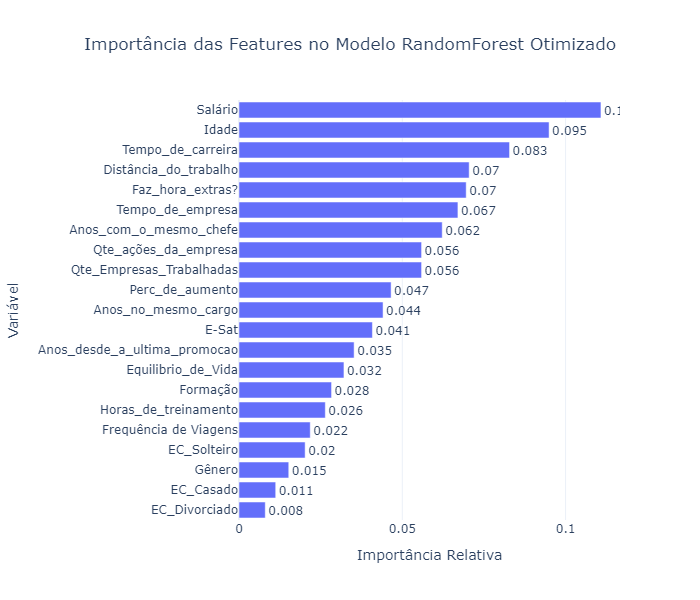

In [21]:
# 1. Extrair as importâncias do modelo otimizado
importances = best_rf_model.feature_importances_
feature_names = X_train.columns # Usar as colunas de X_train (ou X)

# 2. Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 3. Ordenar o DataFrame por importância (do maior para o menor)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Importância das Features (do modelo RandomForest Otimizado):")
display(feature_importance_df.round(4))
print("-" * 60)

# 4. Criar um gráfico de barras para visualizar as importâncias
fig_importance = px.bar(
    feature_importance_df,
    x='Importance',
    y='Feature',
    orientation='h', # Gráfico de barras horizontal
    title='Importância das Features no Modelo RandomForest Otimizado',
    labels={'Importance': 'Importância Relativa', 'Feature': 'Variável'},
    text=feature_importance_df['Importance'].round(3) # Adiciona o valor da importância na barra
)

# Ajustar layout para melhor visualização
fig_importance.update_layout(
    title_x=0.5,
    yaxis={'categoryorder':'total ascending'}, # Ordena o eixo Y pela importância
    height=600 # Ajustar altura conforme necessário
)
fig_importance.update_traces(textposition='outside')

# ---- Salvar e Exibir Imagem Estática ----
# Criar pasta 'images' se não existir
if not os.path.exists("images"):
    os.makedirs("images")

# Salvar a figura como imagem estática
fig_importance_path = "images/fig_feature_importance.png"
fig_importance.write_image(fig_importance_path, engine="kaleido")

# Exibir a imagem no notebook/output
print("\nExibindo Gráfico de Importância das Features:")
display(Image(filename=fig_importance_path))
# fig_importance.show() # Para interativo

**Análise da Importância das Features:**

Observando a tabela ordenada e o gráfico, as features mais importantes que o modelo RandomForest utilizou para prever o turnover foram:
- Salário (0.1108): Consistentemente apontado como crucial, tanto na EDA quanto agora pelo modelo. É o fator de maior importância.
- Idade (0.0949): Também muito importante, confirmando nossa análise de que funcionários mais jovens tendem a sair mais.
- Tempo_de_carreira (0.0828): Esta variável, que está fortemente correlacionada com a Idade e Tempo de Empresa, também aparece com alta importância.
- Distância_do_trabalho (0.0705): Interessante! Na nossa análise de correlação linear simples, a distância tinha uma correlação muito fraca (0.08) com o turnover. No entanto, o RandomForest, que captura relações não-lineares, a colocou como a 4ª mais importante. Pode ser que a distância interaja com outros fatores ou tenha um efeito não linear (ex: distâncias muito curtas ou muito longas sendo mais críticas).
- Faz_hora_extras? (0.0696): Confirma nossa forte descoberta da EDA. Fazer hora extra é um fator relevante para o modelo.
- Tempo_de_empresa (0.0670): Confirma a importância do tempo de vínculo.
- Anos_com_o_mesmo_chefe (0.0622): Outra variável de tempo/estabilidade que o modelo considerou relevante.
- Qte_ações_da_empresa (0.0559): Ter ações da empresa parece ter alguma influência na retenção.
- Qte_Empresas_Trabalhadas (0.0559): O histórico de passagens por outras empresas também foi considerado.
- Perc_de_aumento (0.0466): O percentual de aumento salarial recente tem sua importância.

Alinhamento com a EDA:
Há um forte alinhamento com os principais fatores que identificamos na EDA: Salário, Idade, Horas Extras, Tempo de Empresa. O modelo confirma a relevância desses fatores.
Variáveis como Equilibrio_de_Vida (0.0321) e E-Sat (0.0408), que também se mostraram importantes na EDA (especialmente nos níveis mais baixos), aparecem com importância moderada/baixa aqui. Isso pode ocorrer porque parte da informação delas talvez já esteja capturada por outras variáveis correlacionadas (como Horas Extras e Salário) ou porque seu impacto, embora forte em certos níveis, não é tão discriminatório em toda a faixa de valores quanto os outros fatores para este modelo específico.
A importância relativamente alta de Distância_do_trabalho é uma descoberta interessante do modelo que não era tão óbvia na análise de correlação linear inicial.

---

# Conclusão do Projeto (Notebook/Relatório)


**Conclusão:**
Este projeto teve como objetivo central analisar os fatores que influenciam o turnover de funcionários em uma empresa de tecnologia fictícia e desenvolver um modelo preditivo para identificar colaboradores com maior risco de saída. Através de uma análise exploratória detalhada e da implementação de um modelo RandomForestClassifier, consegui extrair insights valiosos e quantificar a importância de diferentes variáveis.

**Principais Achados:**
Nossa análise revelou que os seguintes fatores estão fortemente associados ao turnover nesta organização:

- Remuneração (Salário): Consistentemente o fator de maior impacto, com funcionários que saem tendo salários significativamente mais baixos.
- Carga de Trabalho (Faz_hora_extras?): Fazer horas extras aumenta drasticamente a probabilidade de saída.
- Estágio na Carreira/Empresa (Idade, Tempo_de_carreira, Tempo_de_empresa): Funcionários mais jovens e com menos tempo de casa/carreira apresentam maior propensão a sair.
- Distância do Trabalho: O modelo identificou a distância como um fator relevante, algo que não era tão evidente apenas na correlação linear.
- Satisfação e Equilíbrio (E-Sat, Equilibrio_de_Vida): Níveis "Baixos" de satisfação e "Ruim" de equilíbrio vida-trabalho são fortes gatilhos para o turnover, conforme visto na EDA.

**Desempenho do Modelo:**
O modelo RandomForest otimizado demonstrou capacidade de identificar padrões, alcançando um Recall de 24% para a classe minoritária ('Sim, Deixou') no conjunto de teste. Embora represente uma melhoria significativa em relação ao modelo base (que tinha ~10% de Recall) e valide a importância dos fatores identificados,é reconhecivel que ainda há uma margem considerável para aprimoramento na capacidade preditiva direta. No entanto, o modelo e a análise de importância das features servem como uma excelente ferramenta de apoio para direcionar as ações de retenção.

**Recomendações para a Empresa:**

Com base nos achados, posso sugerir as seguintes ações prioritárias para o RH e gestores:

- Revisão da Estratégia de Remuneração: Analisar faixas salariais, especialmente para cargos de entrada, funcionários mais jovens e aqueles com menor tempo de casa, garantindo competitividade com o mercado.

- Monitoramento e Gestão da Carga de Trabalho: Investigar as causas das horas extras frequentes e implementar medidas para distribuí-la melhor, contratar mais pessoal se necessário, ou otimizar processos.

- Programas de Engajamento e Desenvolvimento Inicial: Fortalecer o onboarding e criar planos de desenvolvimento claros para os primeiros anos de carreira na empresa, aumentando o senso de pertencimento e perspectiva de crescimento.

- Promoção Ativa do Equilíbrio Vida-Trabalho: Incentivar o uso de férias, avaliar políticas de flexibilidade (horário/local) e conscientizar gestores sobre a importância de respeitar os limites de trabalho.

- Ações Focadas em Baixa Satisfação: Utilizar pesquisas de clima (como o E-Sat) para identificar rapidamente focos de insatisfação e agir de forma direcionada para resolver os problemas apontados.
Análise de Deslocamento: Entender melhor o impacto da distância do trabalho e avaliar possíveis auxílios ou modelos de trabalho híbrido/remoto, se aplicável à função.

**Próximos Passos para o Projeto:**

- Como parte do meu contínuo aprendizado, reconheço que este projeto pode ser aprimorado. Os próximos passos incluiriam:
Experimentação com Outros Algoritmos: Testar modelos como LightGBM, XGBoost ou Regressão Logística, comparando seus desempenhos otimizados via validação cruzada.

- Técnicas Avançadas para Desbalanceamento: Aplicar métodos como SMOTE (Synthetic Minority Over-sampling Technique) para tentar melhorar o Recall da classe minoritária.

- Engenharia de Features: Criar novas variáveis a partir das existentes (ex: relação salário/tempo de empresa) que possam agregar valor preditivo.

- Análise de Segmentos Específicos: Investigar se os fatores de turnover variam entre diferentes departamentos, níveis de cargo ou outras segmentações.
- Desenvolvimento de um Aplicativo Web: Criar uma interface interativa (ex: com Streamlit) para demonstrar o modelo e facilitar a exploração dos resultados.

Este projeto representou um passo importante na minha jornada como estudante de Ciência de Dados, permitindo-me aplicar e consolidar conhecimentos em um problema de negócio relevante.